In [1]:
! pip3 install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 3.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
! pip3 install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 22.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 39.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 27.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [37]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import namedtuple, deque
import math

In [34]:
# Define the DQN network
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [109]:
# Parameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
LR = 1e-4

n_observations = 10 # number of elements in the sequence
n_actions = 10 # number of possible next elements in the sequence
policy_net = DQN(n_observations, n_actions)
target_net = DQN(n_observations, n_actions)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LR)

# Implement Replay Memory
memory = ReplayMemory(10000)

In [80]:


# Training loop
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


# Define action selection function
def select_action(state, steps_done):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)

# state calculator
def one_hot_encode(position, sequence_length):
    state = [0] * sequence_length
    state[position] = 1
    return state

def store_transition(state, action, next_state, reward):
    memory.push(state, action, next_state, torch.tensor([reward]))

def initialize_state(sequence):
    sequence_length = len(sequence)
    state = [0] * sequence_length
    return state

def calculate_state(position, sequence):
    sequence_length = len(sequence)
    return one_hot_encode(position, sequence_length)

def find_next_state(current_state, action, sequence):
    current_position = current_state.index(1)
    if sequence[current_position + 1] == action:
        next_position = current_position + 1
    else:
        next_position = current_position
    return one_hot_encode(next_position, len(sequence))


In [130]:
# Main loop
sequence = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
num_episodes = 150
num_trial = 20
steps_done = 0
# Initialize DQN
policy_net = DQN(n_observations, n_actions)
target_net = DQN(n_observations, n_actions)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LR)

# Implement Replay Memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

memory = ReplayMemory(10000)
episode_rewards = []
episode_lengths = []
for i_episode in range(num_episodes):
    state = calculate_state(0, sequence)
    state = torch.tensor([state], dtype=torch.float32)
    # print("Epoch change ")
    total_reward = 0
    episode_length = 0
    for t in range(num_trial):
        action = select_action(state, steps_done)
        steps_done += 1

        # Assuming the action predicts the next element in the sequence
        predicted_next_element = sequence[action.item()]
        real_next_element = sequence[state[0].tolist().index(1) + 1]

        reward = 1 if predicted_next_element == real_next_element else 0
        next_state = find_next_state(state[0].tolist(), predicted_next_element, sequence)
        # print("Next state",next_state)
        next_state = torch.tensor([next_state], dtype=torch.float32)
        total_reward += reward
        episode_length += 1
        # Check if the end of the sequence is reached
        if state[0].tolist().index(1) == len(sequence) - 2 and predicted_next_element == real_next_element:
            reward = 1  # Assign the large reward
            total_reward += reward - 1
            episode_length += 1
            store_transition(state, action, None, torch.tensor([reward]))  # Store with next_state as None
            break  # End the episode
        
        
        store_transition(state, action, next_state, torch.tensor([reward]))
        state = next_state
        
        # Perform one step of the optimization
        optimize_model()
    episode_rewards.append(total_reward)
    episode_lengths.append(episode_length)

sequence = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
sequence.reverse()
steps_done = 0
print(sequence)
for i_episode in range(num_episodes):
    state = calculate_state(0, sequence)
    state = torch.tensor([state], dtype=torch.float32)
    # print("Epoch change ")
    total_reward = 0
    episode_length = 0
    for t in range(num_trial):
        action = select_action(state, steps_done)
        steps_done += 1

        # Assuming the action predicts the next element in the sequence
        predicted_next_element = sequence[action.item()]
        real_next_element = sequence[state[0].tolist().index(1) + 1]

        reward = 1 if predicted_next_element == real_next_element else 0
        next_state = find_next_state(state[0].tolist(), predicted_next_element, sequence)
        # print("Next state",next_state)
        next_state = torch.tensor([next_state], dtype=torch.float32)
        total_reward += reward
        episode_length += 1
        # Check if the end of the sequence is reached
        if state[0].tolist().index(1) == len(sequence) - 2 and predicted_next_element == real_next_element:
            reward = 1  # Assign the large reward
            total_reward += reward - 1
            episode_length += 1
            store_transition(state, action, None, torch.tensor([reward]))  # Store with next_state as None
            break  # End the episode
        
        
        store_transition(state, action, next_state, torch.tensor([reward]))
        state = next_state
        
        # Perform one step of the optimization
        optimize_model()
    episode_rewards.append(total_reward)
    episode_lengths.append(episode_length)

print('Training complete')

['J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A']
Training complete


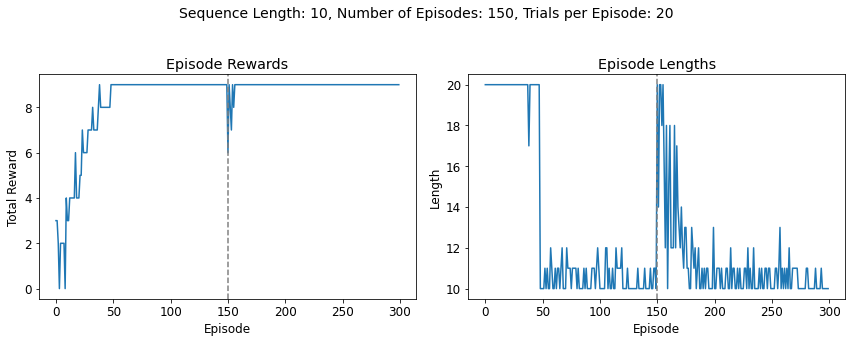

In [131]:
import matplotlib.pyplot as plt

# Assuming sequence_length, num_episodes, and num_trial are defined
sequence_length = len(sequence)  # Replace with actual sequence length if different
# Set font size for plots
plt.rcParams.update({'font.size': 12})

# Plotting
plt.figure(figsize=(12, 5))

# Super title
plt.suptitle(f'Sequence Length: {sequence_length}, Number of Episodes: {num_episodes}, Trials per Episode: {num_trial}', fontsize=14)

# Episode Rewards
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.axvline(x=num_episodes, color='gray', linestyle='--')

# Episode Lengths
plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.axvline(x=num_episodes, color='gray', linestyle='--')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for super title
plt.show()
